# Libraries
Import packages

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import itertools
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import random as random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import  InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3

pd.set_option('max_colwidth', None)

In [2]:
from tensorflow.compat import v1
config = v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = v1.Session(config=config)

# Preparing data

Here we create training and testing datasets.

In [3]:
path ='data/dogs'
dogs = os.listdir(path)
dogs_labels = list(np.ones(len(dogs)))

path ='data/wolves'
wolves = os.listdir(path)
wolves_labels = list(np.zeros(len(wolves)))

In [4]:
paths = dogs + wolves
labels = dogs_labels + wolves_labels

In [5]:
# split into training and test dataset with respect to labels
df = pd.DataFrame({'file':paths, 'label':labels})

df.loc[df['label']==0, 'label'] = 'wolf'
df.loc[df['label']==1, 'label'] = 'dog'


df_train, df_test = train_test_split(df, test_size=0.2, random_state = 101, stratify = df['label'])

print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

print('\nTrain target value counts:')
print(df_train.label.value_counts())

print('\nTest target value counts:')
print(df_test.label.value_counts())

Train shape:  (1600, 2)
Test shape:  (400, 2)

Train target value counts:
dog     800
wolf    800
Name: label, dtype: int64

Test target value counts:
dog     200
wolf    200
Name: label, dtype: int64


# Creating functions that create models

Here we create functions that create our models. They are created in such a way that based on arguments our model has different specifications which is helpful during fine tuning.

In [6]:
# function for CNN models
def build_model_CNN(n_filters, shape_convs, shape_pools, dense):
    # number of output filters
    if n_filters == 1:
        c1 = 32; c2 = 32; c3 = 64; c4 = 64
    elif n_filters == 2:
        c1 = 32; c2 = 64; c3 = 64; c4 = 128
    elif n_filters == 3:
        c1 = 32; c2 = 64; c3 = 128; c4 = 128
    
    #height and width of the 2D convolution window.
    if shape_convs == 1:
        sc1 = 7; sc2 = 5; sc3 = 5; sc4 = 3
    elif shape_convs == 2:
        sc1 = 7; sc2 = 5; sc3 = 3; sc4 = 3
    elif shape_convs == 3:
        sc1 = 5; sc2 = 5; sc3 = 3; sc4 = 3
    elif shape_convs == 4:
        sc1 = 3; sc2 = 3; sc3 = 3; sc4 = 3
    
    # window size over which to take the maximum
    if shape_pools == 1:
        sp1 = 3; sp2 = 3; sp3 = 3; sp4 = 3
    elif shape_pools == 2:
        sp1 = 2; sp2 = 2; sp3 = 2; sp4 = 2

    # dimensionality of the output space in dense layer
    d = dense
    
    params = {'c1':c1,'sc1':sc2,'sp1':sp1,
              'c2':c2,'sc2':sc2,'sp2':sp2,
              'c3':c3,'sc3':sc3,'sp3':sp3,
              'c4':c4,'sc4':sc4,'sp4':sp4}
    
    # create model
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(c1,sc1,input_shape=(img,img,3),activation='relu')) 
    model.add(keras.layers.MaxPooling2D(sp1,2))
    
    model.add(keras.layers.Conv2D(c2,sc2,activation='relu')) 
    model.add(keras.layers.MaxPooling2D(sp2,2))
    
    model.add(keras.layers.Conv2D(c3,sc3,activation='relu')) 
    model.add(keras.layers.MaxPooling2D(sp3,2))
    
    model.add(keras.layers.Conv2D(c4,sc4,activation='relu')) 
    model.add(keras.layers.MaxPooling2D(sp4,2))
    
    model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(d,activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    
    model.compile(loss='binary_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])
    return model

# Reading data

In [7]:
# create image generators with defined image size
# image generator for training data (gen) slightly modifies the data
img = 128
gen_train = ImageDataGenerator(rescale=1.0/255.0,#rescaling
                                rotation_range=45, # random rotations.
                                width_shift_range=0.2, # width shift
                                height_shift_range=0.2,# height shift
                                shear_range=0.2, # shear Intensity
                                zoom_range=0.2, # random zoom
                                horizontal_flip=True, # randomly flip inputs horizontally.
                                fill_mode='nearest'  #Points outside the boundaries of the input are filled according to the given mode
                                )

gen_val = ImageDataGenerator(rescale=1.0/255.0) # only rescaling

In [8]:
# create folder with all data
path = "data/all"
try:
    os.mkdir(path)  
except: 
    pass

# move images to folder with all data
print('Moving dogs photos.')
source_dir = 'data/dogs'
target_dir = 'data/all'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.copy(os.path.join(source_dir, file_name), target_dir)

print('Moving wolves photos.')
source_dir = 'data/wolves'
target_dir = 'data/all'

file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.copy(os.path.join(source_dir, file_name), target_dir)

Moving dogs photos.
Moving wolves photos.


# Train models

## CNN

In [9]:
# dictionary of possible arguments (parameters) for our functions
my_dict = {'n_filters':[1,2,3], 'shape_convs':[1,2,3,4], 'shape_pools':[1,2], 'dense':[128,256,512]}

# creating permuattions of parameters
keys, values = zip(*my_dict.items())
permutations_params = [dict(zip(keys, v)) for v in itertools.product(*values)]

# sampling if there is too many combinations
print("Number of sets before sampling: ", len(permutations_params))
if len(permutations_params) > 20:
    permutations_params = random.sample(permutations_params, 20)
print("Number of sets after sampling: ", len(permutations_params))

Number of sets before sampling:  72
Number of sets after sampling:  20


In [10]:
# loop through parameters, save models and save results
results = []
kf = KFold(n_splits = 5)
for i, params in enumerate(permutations_params):
    print("Parameters set: ",i)
    
    # K-FOLD FOR GIVEN PARAMETER SET 
    history_train = []
    history_valid = []
    for train_index, val_index in kf.split(df_train['file'],df_train['label']):
        # CREATE DATA
        training_data = df_train.iloc[train_index]
        validation_data = df_train.iloc[val_index]

        train_data_generator = gen_train.flow_from_dataframe(
            training_data,
            target_size = (img,img),
            directory = 'data/all',
            x_col = "file",
            y_col = "label",
            class_mode = "binary",
            shuffle = False,
            color_mode = 'rgb',
            batch_size=32,
            seed = 101
        )

        valid_data_generator  = gen_val.flow_from_dataframe(
            validation_data, 
            target_size = (img,img),
            directory = 'data/all',
            x_col = "file",
            y_col = "label",
            class_mode = "binary",
            shuffle = False,
            color_mode = 'rgb',
            batch_size=32,
            seed = 101
        )
    
        # CREATE MODEL
        model = build_model_CNN(n_filters = params['n_filters'], shape_convs = params['shape_convs'], 
                                shape_pools = params['shape_pools'], dense = params['dense'])
        # FIT MODEL
        model.fit(train_data_generator,
                  epochs=100,
                  batch_size = 32,
                  verbose=1
                  )

        # RESULTS
        acc_train = model.evaluate(train_data_generator)[1]
        acc_valid = model.evaluate(valid_data_generator)[1]
        print('Parameters:', params)
        print('Acc train: ', acc_train)
        print('Acc valid: ', acc_valid)
        
        history_train.append(acc_train)
        history_valid.append(acc_valid)
        
    # SAVE RESULTS
    results.append([np.mean(history_train), np.mean(history_valid), params])

Parameters set:  0
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 177ms/step - loss: 0.6932 - accuracy: 0.5398
Epoch 2/100
40/40 [==============================] - 7s 179ms/step - loss: 0.6846 - accuracy: 0.5500
Epoch 3/100
40/40 [==============================] - 7s 179ms/step - loss: 0.6796 - accuracy: 0.5938
Epoch 4/100
40/40 [==============================] - 7s 178ms/step - loss: 0.6320 - accuracy: 0.6492
Epoch 5/100
40/40 [==============================] - 7s 179ms/step - loss: 0.6259 - accuracy: 0.6789
Epoch 6/100
40/40 [==============================] - 7s 178ms/step - loss: 0.6005 - accuracy: 0.6906
Epoch 7/100
40/40 [==============================] - 7s 177ms/step - loss: 0.5699 - accuracy: 0.7188
Epoch 8/100
40/40 [==============================] - 7s 177ms/step - loss: 0.5754 - accuracy: 0.7109
Epoch 9/100
40/40 [==============================] -

Epoch 80/100
40/40 [==============================] - 7s 173ms/step - loss: 0.3775 - accuracy: 0.8320
Epoch 81/100
40/40 [==============================] - 7s 175ms/step - loss: 0.3861 - accuracy: 0.8180
Epoch 82/100
40/40 [==============================] - 7s 175ms/step - loss: 0.3532 - accuracy: 0.8586
Epoch 83/100
40/40 [==============================] - 7s 176ms/step - loss: 0.3619 - accuracy: 0.8445
Epoch 84/100
40/40 [==============================] - 7s 173ms/step - loss: 0.3858 - accuracy: 0.8328
Epoch 85/100
40/40 [==============================] - 7s 175ms/step - loss: 0.3568 - accuracy: 0.8383
Epoch 86/100
40/40 [==============================] - 7s 170ms/step - loss: 0.3861 - accuracy: 0.8438
Epoch 87/100
40/40 [==============================] - 7s 175ms/step - loss: 0.3839 - accuracy: 0.8328
Epoch 88/100
40/40 [==============================] - 7s 173ms/step - loss: 0.3679 - accuracy: 0.8438
Epoch 89/100
40/40 [==============================] - 7s 171ms/step - loss: 0.3728

40/40 [==============================] - 6s 160ms/step - loss: 0.4723 - accuracy: 0.7820
Epoch 57/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5203 - accuracy: 0.7391
Epoch 58/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4849 - accuracy: 0.7680
Epoch 59/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4976 - accuracy: 0.7758
Epoch 60/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4923 - accuracy: 0.7711
Epoch 61/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4876 - accuracy: 0.7758
Epoch 62/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4918 - accuracy: 0.7727
Epoch 63/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4869 - accuracy: 0.7789
Epoch 64/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4836 - accuracy: 0.7812
Epoch 65/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4887 - accuracy: 

40/40 [==============================] - 7s 172ms/step - loss: 0.6874 - accuracy: 0.5406
Epoch 9/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6909 - accuracy: 0.5547
Epoch 10/100
40/40 [==============================] - 7s 168ms/step - loss: 0.6997 - accuracy: 0.5813
Epoch 11/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6700 - accuracy: 0.5836
Epoch 12/100
40/40 [==============================] - 7s 171ms/step - loss: 0.6469 - accuracy: 0.6359
Epoch 13/100
40/40 [==============================] - 7s 167ms/step - loss: 0.6122 - accuracy: 0.6648
Epoch 14/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6098 - accuracy: 0.6852
Epoch 15/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5841 - accuracy: 0.7078
Epoch 16/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5843 - accuracy: 0.7016
Epoch 17/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5606 - accuracy: 0

40/40 [==============================] - 7s 170ms/step - loss: 0.6933 - accuracy: 0.5063
Epoch 65/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6932 - accuracy: 0.5055
Epoch 66/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6932 - accuracy: 0.5039
Epoch 67/100
40/40 [==============================] - 7s 169ms/step - loss: 0.6931 - accuracy: 0.5055
Epoch 68/100
40/40 [==============================] - 7s 168ms/step - loss: 0.6930 - accuracy: 0.5070
Epoch 69/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6930 - accuracy: 0.5070
Epoch 70/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6931 - accuracy: 0.5070
Epoch 71/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6929 - accuracy: 0.5063
Epoch 72/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6933 - accuracy: 0.5047
Epoch 73/100
40/40 [==============================] - 7s 169ms/step - loss: 0.6930 - accuracy: 

40/40 [==============================] - 7s 172ms/step - loss: 0.5153 - accuracy: 0.7656
Epoch 41/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4948 - accuracy: 0.7727
Epoch 42/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4855 - accuracy: 0.7766
Epoch 43/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5168 - accuracy: 0.7523
Epoch 44/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5027 - accuracy: 0.7688
Epoch 45/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4997 - accuracy: 0.7711
Epoch 46/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4960 - accuracy: 0.7688
Epoch 47/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4982 - accuracy: 0.7766
Epoch 48/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4906 - accuracy: 0.7727
Epoch 49/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4792 - accuracy: 

40/40 [==============================] - 6s 162ms/step - loss: 0.4296 - accuracy: 0.8039
Epoch 97/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4267 - accuracy: 0.8133
Epoch 98/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4501 - accuracy: 0.8039
Epoch 99/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4344 - accuracy: 0.7898
Epoch 100/100
10/10 [==============================] - 1s 143ms/step - loss: 0.4124 - accuracy: 0.8188
Parameters: {'n_filters': 1, 'shape_convs': 2, 'shape_pools': 1, 'dense': 128}
Acc train:  0.8125
Acc valid:  0.8187500238418579
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6933 - accuracy: 0.5195
Epoch 2/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6777 - accuracy: 0.5719
Epoch 3/100
40/40 [==============================]

40/40 [==============================] - 7s 171ms/step - loss: 0.4784 - accuracy: 0.7852
Epoch 49/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4708 - accuracy: 0.7859
Epoch 50/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4722 - accuracy: 0.7898
Epoch 51/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4667 - accuracy: 0.7898
Epoch 52/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4768 - accuracy: 0.7812
Epoch 53/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4663 - accuracy: 0.7875
Epoch 54/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4879 - accuracy: 0.7711
Epoch 55/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4882 - accuracy: 0.7719
Epoch 56/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4769 - accuracy: 0.7781
Epoch 57/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4785 - accuracy: 

Epoch 1/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6974 - accuracy: 0.5102
Epoch 2/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6726 - accuracy: 0.5828
Epoch 3/100
40/40 [==============================] - 7s 174ms/step - loss: 0.6331 - accuracy: 0.6500
Epoch 4/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6024 - accuracy: 0.6867
Epoch 5/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5847 - accuracy: 0.7047
Epoch 6/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5441 - accuracy: 0.7375
Epoch 7/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5319 - accuracy: 0.7539
Epoch 8/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5303 - accuracy: 0.7516
Epoch 9/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5013 - accuracy: 0.7664
Epoch 10/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5090 - accura

40/40 [==============================] - 6s 161ms/step - loss: 0.4166 - accuracy: 0.8242
Epoch 58/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4182 - accuracy: 0.8195
Epoch 59/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4099 - accuracy: 0.8211
Epoch 60/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4004 - accuracy: 0.8156
Epoch 61/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4004 - accuracy: 0.8180
Epoch 62/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4096 - accuracy: 0.8266
Epoch 63/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4068 - accuracy: 0.8188
Epoch 64/100
40/40 [==============================] - 6s 161ms/step - loss: 0.3989 - accuracy: 0.8336
Epoch 65/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4172 - accuracy: 0.8266
Epoch 66/100
40/40 [==============================] - 6s 162ms/step - loss: 0.3881 - accuracy: 

40/40 [==============================] - 7s 173ms/step - loss: 0.5709 - accuracy: 0.7055
Epoch 10/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5341 - accuracy: 0.7359
Epoch 11/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5261 - accuracy: 0.7484
Epoch 12/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5169 - accuracy: 0.7492
Epoch 13/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5051 - accuracy: 0.7727
Epoch 14/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5021 - accuracy: 0.7539
Epoch 15/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5029 - accuracy: 0.7648
Epoch 16/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5113 - accuracy: 0.7477
Epoch 17/100
40/40 [==============================] - 7s 168ms/step - loss: 0.4958 - accuracy: 0.7695
Epoch 18/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4863 - accuracy: 

40/40 [==============================] - 7s 169ms/step - loss: 0.3846 - accuracy: 0.8242
Epoch 66/100
40/40 [==============================] - 7s 170ms/step - loss: 0.3851 - accuracy: 0.8313
Epoch 67/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4041 - accuracy: 0.8258
Epoch 68/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3741 - accuracy: 0.8234
Epoch 69/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3984 - accuracy: 0.8242
Epoch 70/100
40/40 [==============================] - 7s 170ms/step - loss: 0.3867 - accuracy: 0.8242
Epoch 71/100
40/40 [==============================] - 7s 168ms/step - loss: 0.3970 - accuracy: 0.8258
Epoch 72/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3734 - accuracy: 0.8367
Epoch 73/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3733 - accuracy: 0.8305
Epoch 74/100
40/40 [==============================] - 7s 165ms/step - loss: 0.3662 - accuracy: 

40/40 [==============================] - 7s 174ms/step - loss: 0.5060 - accuracy: 0.7469
Epoch 42/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5007 - accuracy: 0.7656
Epoch 43/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4877 - accuracy: 0.7797
Epoch 44/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4981 - accuracy: 0.7656
Epoch 45/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5158 - accuracy: 0.7570
Epoch 46/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4996 - accuracy: 0.7820
Epoch 47/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4964 - accuracy: 0.7820
Epoch 48/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4909 - accuracy: 0.7852
Epoch 49/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5106 - accuracy: 0.7445
Epoch 50/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5834 - accuracy: 

40/40 [==============================] - 6s 162ms/step - loss: 0.5189 - accuracy: 0.7586
Epoch 98/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4884 - accuracy: 0.7719
Epoch 99/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4865 - accuracy: 0.7672
Epoch 100/100
10/10 [==============================] - 1s 143ms/step - loss: 0.4243 - accuracy: 0.7937
Parameters: {'n_filters': 3, 'shape_convs': 1, 'shape_pools': 2, 'dense': 128}
Acc train:  0.7875000238418579
Acc valid:  0.793749988079071
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6987 - accuracy: 0.4914
Epoch 2/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6935 - accuracy: 0.5070
Epoch 3/100
40/40 [==============================] - 7s 171ms/step - loss: 0.6929 - accuracy: 0.5406
Epoch 4/100
40/40 [=====================

40/40 [==============================] - 7s 172ms/step - loss: 0.5272 - accuracy: 0.7383
Epoch 50/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5178 - accuracy: 0.7406
Epoch 51/100
40/40 [==============================] - 7s 168ms/step - loss: 0.5202 - accuracy: 0.7422
Epoch 52/100
40/40 [==============================] - 7s 168ms/step - loss: 0.5074 - accuracy: 0.7617
Epoch 53/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5118 - accuracy: 0.7492
Epoch 54/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5122 - accuracy: 0.7469
Epoch 55/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5056 - accuracy: 0.7617
Epoch 56/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5067 - accuracy: 0.7695
Epoch 57/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4969 - accuracy: 0.7586
Epoch 58/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4928 - accuracy: 

Epoch 1/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6976 - accuracy: 0.4992
Epoch 2/100
40/40 [==============================] - 7s 169ms/step - loss: 0.6788 - accuracy: 0.5867
Epoch 3/100
40/40 [==============================] - 7s 174ms/step - loss: 0.6213 - accuracy: 0.6734
Epoch 4/100
40/40 [==============================] - 7s 175ms/step - loss: 0.6218 - accuracy: 0.6570
Epoch 5/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5878 - accuracy: 0.6984
Epoch 6/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5735 - accuracy: 0.6992
Epoch 7/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5684 - accuracy: 0.7133
Epoch 8/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5717 - accuracy: 0.7172
Epoch 9/100
40/40 [==============================] - 7s 176ms/step - loss: 0.5528 - accuracy: 0.7383
Epoch 10/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6017 - accura

40/40 [==============================] - 6s 162ms/step - loss: 0.5311 - accuracy: 0.7492
Epoch 58/100
40/40 [==============================] - 6s 159ms/step - loss: 0.5156 - accuracy: 0.7633
Epoch 59/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5333 - accuracy: 0.7375
Epoch 60/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5162 - accuracy: 0.7578
Epoch 61/100
40/40 [==============================] - 7s 164ms/step - loss: 0.5204 - accuracy: 0.7516
Epoch 62/100
40/40 [==============================] - 6s 161ms/step - loss: 0.5215 - accuracy: 0.7430
Epoch 63/100
40/40 [==============================] - 6s 158ms/step - loss: 0.5342 - accuracy: 0.7453
Epoch 64/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5178 - accuracy: 0.7633
Epoch 65/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5203 - accuracy: 0.7633
Epoch 66/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5338 - accuracy: 

40/40 [==============================] - 7s 171ms/step - loss: 0.5966 - accuracy: 0.6898
Epoch 10/100
40/40 [==============================] - 7s 171ms/step - loss: 0.6068 - accuracy: 0.6766
Epoch 11/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5944 - accuracy: 0.6789
Epoch 12/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5968 - accuracy: 0.6781
Epoch 13/100
40/40 [==============================] - 7s 167ms/step - loss: 0.5754 - accuracy: 0.7078
Epoch 14/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5766 - accuracy: 0.7008
Epoch 15/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5721 - accuracy: 0.7086
Epoch 16/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5707 - accuracy: 0.6992
Epoch 17/100
40/40 [==============================] - 7s 167ms/step - loss: 0.5564 - accuracy: 0.7297
Epoch 18/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5515 - accuracy: 

40/40 [==============================] - 7s 170ms/step - loss: 0.4850 - accuracy: 0.7742
Epoch 66/100
40/40 [==============================] - 7s 168ms/step - loss: 0.4990 - accuracy: 0.7617
Epoch 67/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4819 - accuracy: 0.7758
Epoch 68/100
40/40 [==============================] - 7s 166ms/step - loss: 0.5030 - accuracy: 0.7648
Epoch 69/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4786 - accuracy: 0.7750
Epoch 70/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4936 - accuracy: 0.7625
Epoch 71/100
40/40 [==============================] - 7s 168ms/step - loss: 0.4882 - accuracy: 0.7750
Epoch 72/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4654 - accuracy: 0.7914
Epoch 73/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4841 - accuracy: 0.7805
Epoch 74/100
40/40 [==============================] - 7s 167ms/step - loss: 0.4673 - accuracy: 

40/40 [==============================] - 7s 175ms/step - loss: 0.4630 - accuracy: 0.7891
Epoch 42/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4759 - accuracy: 0.7930
Epoch 43/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4960 - accuracy: 0.7828
Epoch 44/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4819 - accuracy: 0.7883
Epoch 45/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4877 - accuracy: 0.7859
Epoch 46/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4667 - accuracy: 0.7977
Epoch 47/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4633 - accuracy: 0.7984
Epoch 48/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4585 - accuracy: 0.8023
Epoch 49/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4582 - accuracy: 0.7992
Epoch 50/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4518 - accuracy: 

40/40 [==============================] - 6s 162ms/step - loss: 0.4168 - accuracy: 0.8094
Epoch 98/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4412 - accuracy: 0.7961
Epoch 99/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4253 - accuracy: 0.7992
Epoch 100/100
10/10 [==============================] - 1s 143ms/step - loss: 0.3647 - accuracy: 0.8531
Parameters: {'n_filters': 2, 'shape_convs': 2, 'shape_pools': 1, 'dense': 512}
Acc train:  0.8226562738418579
Acc valid:  0.8531249761581421
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6929 - accuracy: 0.5469
Epoch 2/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6533 - accuracy: 0.6508
Epoch 3/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6775 - accuracy: 0.5547
Epoch 4/100
40/40 [====================

40/40 [==============================] - 7s 171ms/step - loss: 0.5122 - accuracy: 0.7477
Epoch 50/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5164 - accuracy: 0.7492
Epoch 51/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5242 - accuracy: 0.7359
Epoch 52/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5476 - accuracy: 0.7250
Epoch 53/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5464 - accuracy: 0.7344
Epoch 54/100
40/40 [==============================] - 7s 167ms/step - loss: 0.5168 - accuracy: 0.7492
Epoch 55/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5093 - accuracy: 0.7555
Epoch 56/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5135 - accuracy: 0.7578
Epoch 57/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5145 - accuracy: 0.7469
Epoch 58/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4931 - accuracy: 

Epoch 1/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6889 - accuracy: 0.5336
Epoch 2/100
40/40 [==============================] - 7s 175ms/step - loss: 0.6843 - accuracy: 0.5508
Epoch 3/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6518 - accuracy: 0.6422
Epoch 4/100
40/40 [==============================] - 7s 174ms/step - loss: 0.6143 - accuracy: 0.6828
Epoch 5/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5782 - accuracy: 0.7086
Epoch 6/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5731 - accuracy: 0.7125
Epoch 7/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5578 - accuracy: 0.7273
Epoch 8/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5449 - accuracy: 0.7266
Epoch 9/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5407 - accuracy: 0.7359
Epoch 10/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5135 - accura

40/40 [==============================] - 6s 161ms/step - loss: 0.4153 - accuracy: 0.8055
Epoch 58/100
40/40 [==============================] - 6s 160ms/step - loss: 0.3822 - accuracy: 0.8383
Epoch 59/100
40/40 [==============================] - 6s 161ms/step - loss: 0.3873 - accuracy: 0.8336
Epoch 60/100
40/40 [==============================] - 6s 161ms/step - loss: 0.3820 - accuracy: 0.8313
Epoch 61/100
40/40 [==============================] - 6s 162ms/step - loss: 0.3960 - accuracy: 0.8148
Epoch 62/100
40/40 [==============================] - 6s 161ms/step - loss: 0.3848 - accuracy: 0.8273
Epoch 63/100
40/40 [==============================] - 6s 162ms/step - loss: 0.3812 - accuracy: 0.8344
Epoch 64/100
40/40 [==============================] - 6s 161ms/step - loss: 0.3820 - accuracy: 0.8359
Epoch 65/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4040 - accuracy: 0.8281
Epoch 66/100
40/40 [==============================] - 6s 160ms/step - loss: 0.3663 - accuracy: 

40/40 [==============================] - 7s 171ms/step - loss: 0.5467 - accuracy: 0.7320
Epoch 10/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5321 - accuracy: 0.7508
Epoch 11/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5150 - accuracy: 0.7453
Epoch 12/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5174 - accuracy: 0.7523
Epoch 13/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5079 - accuracy: 0.7586
Epoch 14/100
40/40 [==============================] - 7s 168ms/step - loss: 0.5261 - accuracy: 0.7453
Epoch 15/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5089 - accuracy: 0.7594
Epoch 16/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5137 - accuracy: 0.7484
Epoch 17/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4805 - accuracy: 0.7758
Epoch 18/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4863 - accuracy: 

40/40 [==============================] - 7s 167ms/step - loss: 0.3853 - accuracy: 0.8289
Epoch 66/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3805 - accuracy: 0.8398
Epoch 67/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3844 - accuracy: 0.8320
Epoch 68/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3788 - accuracy: 0.8406
Epoch 69/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3928 - accuracy: 0.8227
Epoch 70/100
40/40 [==============================] - 7s 170ms/step - loss: 0.3712 - accuracy: 0.8391
Epoch 71/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3593 - accuracy: 0.8391
Epoch 72/100
40/40 [==============================] - 7s 166ms/step - loss: 0.3592 - accuracy: 0.8313
Epoch 73/100
40/40 [==============================] - 7s 170ms/step - loss: 0.3631 - accuracy: 0.8430
Epoch 74/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3446 - accuracy: 

40/40 [==============================] - 7s 173ms/step - loss: 0.4258 - accuracy: 0.8109
Epoch 42/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4250 - accuracy: 0.8094
Epoch 43/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4269 - accuracy: 0.8156
Epoch 44/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4169 - accuracy: 0.8164
Epoch 45/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4306 - accuracy: 0.8062
Epoch 46/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4283 - accuracy: 0.8148
Epoch 47/100
40/40 [==============================] - 7s 174ms/step - loss: 0.3966 - accuracy: 0.8211
Epoch 48/100
40/40 [==============================] - 7s 170ms/step - loss: 0.3921 - accuracy: 0.8297
Epoch 49/100
40/40 [==============================] - 7s 174ms/step - loss: 0.3972 - accuracy: 0.8320
Epoch 50/100
40/40 [==============================] - 7s 174ms/step - loss: 0.3981 - accuracy: 

40/40 [==============================] - 6s 161ms/step - loss: 0.2963 - accuracy: 0.8750
Epoch 98/100
40/40 [==============================] - 6s 162ms/step - loss: 0.3020 - accuracy: 0.8703
Epoch 99/100
40/40 [==============================] - 6s 162ms/step - loss: 0.3182 - accuracy: 0.8641
Epoch 100/100
10/10 [==============================] - 1s 143ms/step - loss: 0.4713 - accuracy: 0.8094
Parameters: {'n_filters': 1, 'shape_convs': 4, 'shape_pools': 1, 'dense': 256}
Acc train:  0.8828125
Acc valid:  0.809374988079071
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6976 - accuracy: 0.5219
Epoch 2/100
40/40 [==============================] - 7s 169ms/step - loss: 0.6711 - accuracy: 0.6031
Epoch 3/100
40/40 [==============================] - 7s 171ms/step - loss: 0.6211 - accuracy: 0.6758
Epoch 4/100
40/40 [==============================

40/40 [==============================] - 7s 170ms/step - loss: 0.4087 - accuracy: 0.8195
Epoch 50/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4008 - accuracy: 0.8313
Epoch 51/100
40/40 [==============================] - 7s 171ms/step - loss: 0.3929 - accuracy: 0.8367
Epoch 52/100
40/40 [==============================] - 7s 168ms/step - loss: 0.3839 - accuracy: 0.8391
Epoch 53/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4019 - accuracy: 0.8172
Epoch 54/100
40/40 [==============================] - 7s 168ms/step - loss: 0.3917 - accuracy: 0.8227
Epoch 55/100
40/40 [==============================] - 7s 170ms/step - loss: 0.3799 - accuracy: 0.8336
Epoch 56/100
40/40 [==============================] - 7s 172ms/step - loss: 0.3925 - accuracy: 0.8219
Epoch 57/100
40/40 [==============================] - 7s 168ms/step - loss: 0.3693 - accuracy: 0.8391
Epoch 58/100
40/40 [==============================] - 7s 170ms/step - loss: 0.3679 - accuracy: 

Epoch 1/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6801 - accuracy: 0.5437
Epoch 2/100
40/40 [==============================] - 7s 174ms/step - loss: 0.6504 - accuracy: 0.6352
Epoch 3/100
40/40 [==============================] - 7s 176ms/step - loss: 0.6561 - accuracy: 0.6211
Epoch 4/100
40/40 [==============================] - 7s 175ms/step - loss: 0.6205 - accuracy: 0.6602
Epoch 5/100
40/40 [==============================] - 7s 175ms/step - loss: 0.6061 - accuracy: 0.6906
Epoch 6/100
40/40 [==============================] - 7s 174ms/step - loss: 0.6112 - accuracy: 0.6742
Epoch 7/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5758 - accuracy: 0.7156
Epoch 8/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5549 - accuracy: 0.7352
Epoch 9/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5432 - accuracy: 0.7336
Epoch 10/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5298 - accura

40/40 [==============================] - 6s 162ms/step - loss: 0.5409 - accuracy: 0.7453
Epoch 58/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5400 - accuracy: 0.7469
Epoch 59/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5275 - accuracy: 0.7477
Epoch 60/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5217 - accuracy: 0.7531
Epoch 61/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5433 - accuracy: 0.7367
Epoch 62/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5246 - accuracy: 0.7594
Epoch 63/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5349 - accuracy: 0.7430
Epoch 64/100
40/40 [==============================] - 6s 160ms/step - loss: 0.5413 - accuracy: 0.7336
Epoch 65/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5337 - accuracy: 0.7570
Epoch 66/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5310 - accuracy: 

40/40 [==============================] - 7s 171ms/step - loss: 0.5746 - accuracy: 0.7000
Epoch 10/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5687 - accuracy: 0.7063
Epoch 11/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5850 - accuracy: 0.6883
Epoch 12/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5619 - accuracy: 0.7266
Epoch 13/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5652 - accuracy: 0.7078
Epoch 14/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5419 - accuracy: 0.7328
Epoch 15/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5472 - accuracy: 0.7164
Epoch 16/100
40/40 [==============================] - 7s 167ms/step - loss: 0.5606 - accuracy: 0.7172
Epoch 17/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5326 - accuracy: 0.7344
Epoch 18/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5490 - accuracy: 

40/40 [==============================] - 7s 170ms/step - loss: 0.5156 - accuracy: 0.7594
Epoch 66/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4988 - accuracy: 0.7758
Epoch 67/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5071 - accuracy: 0.7641
Epoch 68/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5092 - accuracy: 0.7516
Epoch 69/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4864 - accuracy: 0.7797
Epoch 70/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4950 - accuracy: 0.7758
Epoch 71/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4898 - accuracy: 0.7719
Epoch 72/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4889 - accuracy: 0.7625
Epoch 73/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5237 - accuracy: 0.7500
Epoch 74/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5078 - accuracy: 

40/40 [==============================] - 7s 173ms/step - loss: 0.4472 - accuracy: 0.8039
Epoch 42/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4485 - accuracy: 0.7961
Epoch 43/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4391 - accuracy: 0.8117
Epoch 44/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4524 - accuracy: 0.8031
Epoch 45/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4542 - accuracy: 0.7953
Epoch 46/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4412 - accuracy: 0.7992
Epoch 47/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4372 - accuracy: 0.8117
Epoch 48/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4455 - accuracy: 0.8102
Epoch 49/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4402 - accuracy: 0.8055
Epoch 50/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4277 - accuracy: 

40/40 [==============================] - 6s 162ms/step - loss: 0.4263 - accuracy: 0.8109
Epoch 98/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4273 - accuracy: 0.8078
Epoch 99/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4483 - accuracy: 0.7859
Epoch 100/100
10/10 [==============================] - 1s 142ms/step - loss: 0.4321 - accuracy: 0.7969
Parameters: {'n_filters': 1, 'shape_convs': 3, 'shape_pools': 2, 'dense': 256}
Acc train:  0.792187511920929
Acc valid:  0.796875
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6973 - accuracy: 0.5016
Epoch 2/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6924 - accuracy: 0.5414
Epoch 3/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6527 - accuracy: 0.6281
Epoch 4/100
40/40 [==============================]

40/40 [==============================] - 7s 171ms/step - loss: 0.4795 - accuracy: 0.7703
Epoch 50/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4526 - accuracy: 0.7883
Epoch 51/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4584 - accuracy: 0.7891
Epoch 52/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4740 - accuracy: 0.7703
Epoch 53/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4765 - accuracy: 0.7734
Epoch 54/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4591 - accuracy: 0.7852
Epoch 55/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4408 - accuracy: 0.7937
Epoch 56/100
40/40 [==============================] - 7s 168ms/step - loss: 0.4599 - accuracy: 0.7930
Epoch 57/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4473 - accuracy: 0.7945
Epoch 58/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4562 - accuracy: 

Epoch 1/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6956 - accuracy: 0.5047
Epoch 2/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6751 - accuracy: 0.6055
Epoch 3/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6496 - accuracy: 0.6414
Epoch 4/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6069 - accuracy: 0.6906
Epoch 5/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5921 - accuracy: 0.6953
Epoch 6/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6133 - accuracy: 0.6703
Epoch 7/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5966 - accuracy: 0.6914
Epoch 8/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5756 - accuracy: 0.7086
Epoch 9/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5609 - accuracy: 0.7219
Epoch 10/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5543 - accura

40/40 [==============================] - 7s 163ms/step - loss: 0.4956 - accuracy: 0.7727
Epoch 58/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5007 - accuracy: 0.7680
Epoch 59/100
40/40 [==============================] - 7s 163ms/step - loss: 0.5017 - accuracy: 0.7672
Epoch 60/100
40/40 [==============================] - 6s 161ms/step - loss: 0.5188 - accuracy: 0.7484
Epoch 61/100
40/40 [==============================] - 6s 158ms/step - loss: 0.4966 - accuracy: 0.7570
Epoch 62/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4911 - accuracy: 0.7703
Epoch 63/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5205 - accuracy: 0.7484
Epoch 64/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4825 - accuracy: 0.7805
Epoch 65/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4777 - accuracy: 0.7812
Epoch 66/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4914 - accuracy: 

40/40 [==============================] - 7s 171ms/step - loss: 0.6276 - accuracy: 0.6570
Epoch 10/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5903 - accuracy: 0.6961
Epoch 11/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5819 - accuracy: 0.7102
Epoch 12/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5688 - accuracy: 0.7164
Epoch 13/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5461 - accuracy: 0.7352
Epoch 14/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5638 - accuracy: 0.7086
Epoch 15/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5491 - accuracy: 0.7266
Epoch 16/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5353 - accuracy: 0.7437
Epoch 17/100
40/40 [==============================] - 7s 168ms/step - loss: 0.5430 - accuracy: 0.7414
Epoch 18/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5444 - accuracy: 

40/40 [==============================] - 7s 169ms/step - loss: 0.4432 - accuracy: 0.7984
Epoch 66/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4277 - accuracy: 0.8133
Epoch 67/100
40/40 [==============================] - 7s 168ms/step - loss: 0.4137 - accuracy: 0.8148
Epoch 68/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4442 - accuracy: 0.7992
Epoch 69/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4607 - accuracy: 0.7875
Epoch 70/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4328 - accuracy: 0.8031
Epoch 71/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4303 - accuracy: 0.8117
Epoch 72/100
40/40 [==============================] - 7s 168ms/step - loss: 0.4356 - accuracy: 0.8016
Epoch 73/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4362 - accuracy: 0.7906
Epoch 74/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4309 - accuracy: 

40/40 [==============================] - 7s 174ms/step - loss: 0.4253 - accuracy: 0.8156
Epoch 42/100
40/40 [==============================] - 7s 176ms/step - loss: 0.4291 - accuracy: 0.8141
Epoch 43/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4388 - accuracy: 0.8039
Epoch 44/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4106 - accuracy: 0.8297
Epoch 45/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4260 - accuracy: 0.8125
Epoch 46/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4150 - accuracy: 0.8227
Epoch 47/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4070 - accuracy: 0.8250
Epoch 48/100
40/40 [==============================] - 7s 175ms/step - loss: 0.3999 - accuracy: 0.8250
Epoch 49/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4107 - accuracy: 0.8242
Epoch 50/100
40/40 [==============================] - 7s 174ms/step - loss: 0.3975 - accuracy: 

40/40 [==============================] - 7s 163ms/step - loss: 0.3386 - accuracy: 0.8516
Epoch 98/100
40/40 [==============================] - 7s 163ms/step - loss: 0.3193 - accuracy: 0.8633
Epoch 99/100
40/40 [==============================] - 6s 161ms/step - loss: 0.2921 - accuracy: 0.8750
Epoch 100/100
10/10 [==============================] - 1s 143ms/step - loss: 0.3507 - accuracy: 0.8594
Parameters: {'n_filters': 3, 'shape_convs': 4, 'shape_pools': 1, 'dense': 512}
Acc train:  0.890625
Acc valid:  0.859375
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6990 - accuracy: 0.5047
Epoch 2/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6757 - accuracy: 0.5797
Epoch 3/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6559 - accuracy: 0.6398
Epoch 4/100
40/40 [==============================] - 7s 173

40/40 [==============================] - 7s 172ms/step - loss: 0.4298 - accuracy: 0.8203
Epoch 50/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4150 - accuracy: 0.8094
Epoch 51/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4130 - accuracy: 0.8141
Epoch 52/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4091 - accuracy: 0.8164
Epoch 53/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4322 - accuracy: 0.8039
Epoch 54/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4299 - accuracy: 0.8055
Epoch 55/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4228 - accuracy: 0.8219
Epoch 56/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4174 - accuracy: 0.8086
Epoch 57/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4213 - accuracy: 0.8141
Epoch 58/100
40/40 [==============================] - 7s 172ms/step - loss: 0.3973 - accuracy: 

Epoch 1/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6931 - accuracy: 0.5312
Epoch 2/100
40/40 [==============================] - 7s 174ms/step - loss: 0.6501 - accuracy: 0.6320
Epoch 3/100
40/40 [==============================] - 7s 176ms/step - loss: 0.6385 - accuracy: 0.6492
Epoch 4/100
40/40 [==============================] - 7s 176ms/step - loss: 0.6008 - accuracy: 0.6820
Epoch 5/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5929 - accuracy: 0.6961
Epoch 6/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5809 - accuracy: 0.7086
Epoch 7/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5639 - accuracy: 0.7266
Epoch 8/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5406 - accuracy: 0.7359
Epoch 9/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5474 - accuracy: 0.7297
Epoch 10/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5363 - accura

40/40 [==============================] - 7s 167ms/step - loss: 0.4862 - accuracy: 0.7742
Epoch 58/100
40/40 [==============================] - 7s 167ms/step - loss: 0.5032 - accuracy: 0.7625
Epoch 59/100
40/40 [==============================] - 7s 165ms/step - loss: 0.4902 - accuracy: 0.7828
Epoch 60/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4898 - accuracy: 0.7750
Epoch 61/100
40/40 [==============================] - 7s 168ms/step - loss: 0.4862 - accuracy: 0.7875
Epoch 62/100
40/40 [==============================] - 7s 168ms/step - loss: 0.4820 - accuracy: 0.7789
Epoch 63/100
40/40 [==============================] - 7s 166ms/step - loss: 0.4739 - accuracy: 0.7891
Epoch 64/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4962 - accuracy: 0.7758
Epoch 65/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4935 - accuracy: 0.7719
Epoch 66/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4739 - accuracy: 

40/40 [==============================] - 7s 172ms/step - loss: 0.5600 - accuracy: 0.7266
Epoch 10/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5894 - accuracy: 0.6773
Epoch 11/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5807 - accuracy: 0.7086
Epoch 12/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5677 - accuracy: 0.7258
Epoch 13/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5421 - accuracy: 0.7227
Epoch 14/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5464 - accuracy: 0.7312
Epoch 15/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5447 - accuracy: 0.7414
Epoch 16/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5375 - accuracy: 0.7391
Epoch 17/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5508 - accuracy: 0.7344
Epoch 18/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5159 - accuracy: 

40/40 [==============================] - 7s 167ms/step - loss: 0.4546 - accuracy: 0.8031
Epoch 66/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4507 - accuracy: 0.7953
Epoch 67/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4626 - accuracy: 0.7781
Epoch 68/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4479 - accuracy: 0.8055
Epoch 69/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4514 - accuracy: 0.7828
Epoch 70/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4453 - accuracy: 0.7969
Epoch 71/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4381 - accuracy: 0.8008
Epoch 72/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4522 - accuracy: 0.7945
Epoch 73/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4488 - accuracy: 0.7961
Epoch 74/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4570 - accuracy: 

40/40 [==============================] - 7s 174ms/step - loss: 0.4762 - accuracy: 0.7695
Epoch 42/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4833 - accuracy: 0.7688
Epoch 43/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4762 - accuracy: 0.7875
Epoch 44/100
40/40 [==============================] - 7s 176ms/step - loss: 0.4694 - accuracy: 0.7984
Epoch 45/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4710 - accuracy: 0.7836
Epoch 46/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4749 - accuracy: 0.7883
Epoch 47/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4851 - accuracy: 0.7672
Epoch 48/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4567 - accuracy: 0.7977
Epoch 49/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4625 - accuracy: 0.7953
Epoch 50/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4523 - accuracy: 

40/40 [==============================] - 7s 163ms/step - loss: 0.4994 - accuracy: 0.7719
Epoch 98/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4841 - accuracy: 0.7742
Epoch 99/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4885 - accuracy: 0.7688
Epoch 100/100
10/10 [==============================] - 1s 144ms/step - loss: 0.4444 - accuracy: 0.8031
Parameters: {'n_filters': 2, 'shape_convs': 1, 'shape_pools': 2, 'dense': 128}
Acc train:  0.785937488079071
Acc valid:  0.8031250238418579
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6969 - accuracy: 0.5000
Epoch 2/100
40/40 [==============================] - 7s 169ms/step - loss: 0.6937 - accuracy: 0.4992
Epoch 3/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6927 - accuracy: 0.5188
Epoch 4/100
40/40 [=====================

40/40 [==============================] - 7s 173ms/step - loss: 0.5123 - accuracy: 0.7625
Epoch 50/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5129 - accuracy: 0.7625
Epoch 51/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5164 - accuracy: 0.7500
Epoch 52/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5049 - accuracy: 0.7594
Epoch 53/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4981 - accuracy: 0.7602
Epoch 54/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4958 - accuracy: 0.7586
Epoch 55/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5243 - accuracy: 0.7539
Epoch 56/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4924 - accuracy: 0.7586
Epoch 57/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5119 - accuracy: 0.7570
Epoch 58/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4977 - accuracy: 

40/40 [==============================] - 7s 172ms/step - loss: 0.6977 - accuracy: 0.5172
Epoch 2/100
40/40 [==============================] - 7s 175ms/step - loss: 0.6561 - accuracy: 0.5992
Epoch 3/100
40/40 [==============================] - 7s 175ms/step - loss: 0.6278 - accuracy: 0.6836
Epoch 4/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5861 - accuracy: 0.6984
Epoch 5/100
40/40 [==============================] - 7s 171ms/step - loss: 0.6172 - accuracy: 0.6602
Epoch 6/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5749 - accuracy: 0.7234
Epoch 7/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5834 - accuracy: 0.6953
Epoch 8/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5571 - accuracy: 0.7164
Epoch 9/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5364 - accuracy: 0.7281
Epoch 10/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5446 - accuracy: 0.7406
E

40/40 [==============================] - 6s 161ms/step - loss: 0.4682 - accuracy: 0.7758
Epoch 58/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4576 - accuracy: 0.8016
Epoch 59/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4841 - accuracy: 0.7789
Epoch 60/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4616 - accuracy: 0.8031
Epoch 61/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4857 - accuracy: 0.7812
Epoch 62/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4735 - accuracy: 0.7852
Epoch 63/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4567 - accuracy: 0.7953
Epoch 64/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4497 - accuracy: 0.7937
Epoch 65/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4410 - accuracy: 0.7945
Epoch 66/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4618 - accuracy: 

40/40 [==============================] - 7s 171ms/step - loss: 0.5745 - accuracy: 0.7008
Epoch 10/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5568 - accuracy: 0.7125
Epoch 11/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5460 - accuracy: 0.7172
Epoch 12/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5497 - accuracy: 0.7227
Epoch 13/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5509 - accuracy: 0.7437
Epoch 14/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5374 - accuracy: 0.7352
Epoch 15/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5343 - accuracy: 0.7453
Epoch 16/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5132 - accuracy: 0.7602
Epoch 17/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5265 - accuracy: 0.7430
Epoch 18/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5158 - accuracy: 

40/40 [==============================] - 7s 166ms/step - loss: 0.4428 - accuracy: 0.8039
Epoch 66/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4276 - accuracy: 0.7937
Epoch 67/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4476 - accuracy: 0.7977
Epoch 68/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4175 - accuracy: 0.8062
Epoch 69/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4128 - accuracy: 0.8180
Epoch 70/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4085 - accuracy: 0.8125
Epoch 71/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4042 - accuracy: 0.8234
Epoch 72/100
40/40 [==============================] - 7s 166ms/step - loss: 0.4141 - accuracy: 0.8156
Epoch 73/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4136 - accuracy: 0.8250
Epoch 74/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3932 - accuracy: 

40/40 [==============================] - 7s 175ms/step - loss: 0.4540 - accuracy: 0.7961
Epoch 42/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4842 - accuracy: 0.7750
Epoch 43/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4707 - accuracy: 0.7875
Epoch 44/100
40/40 [==============================] - 7s 176ms/step - loss: 0.4879 - accuracy: 0.7695
Epoch 45/100
40/40 [==============================] - 7s 176ms/step - loss: 0.4651 - accuracy: 0.7891
Epoch 46/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4707 - accuracy: 0.7992
Epoch 47/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4761 - accuracy: 0.7820
Epoch 48/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4561 - accuracy: 0.7922
Epoch 49/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4576 - accuracy: 0.7906
Epoch 50/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4711 - accuracy: 

40/40 [==============================] - 7s 163ms/step - loss: 0.4934 - accuracy: 0.7609
Epoch 98/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4881 - accuracy: 0.7719
Epoch 99/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4742 - accuracy: 0.7711
Epoch 100/100
10/10 [==============================] - 1s 143ms/step - loss: 0.5086 - accuracy: 0.7875
Parameters: {'n_filters': 2, 'shape_convs': 2, 'shape_pools': 2, 'dense': 256}
Acc train:  0.7632812261581421
Acc valid:  0.7875000238418579
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6997 - accuracy: 0.4953
Epoch 2/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6902 - accuracy: 0.5227
Epoch 3/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6867 - accuracy: 0.5180
Epoch 4/100
40/40 [====================

Epoch 73/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4886 - accuracy: 0.7648
Epoch 74/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4957 - accuracy: 0.7688
Epoch 75/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4906 - accuracy: 0.7836
Epoch 76/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4763 - accuracy: 0.7695
Epoch 77/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4787 - accuracy: 0.7758
Epoch 78/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4690 - accuracy: 0.7867
Epoch 79/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4773 - accuracy: 0.7773
Epoch 80/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4754 - accuracy: 0.7898
Epoch 81/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4877 - accuracy: 0.7781
Epoch 82/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4643

40/40 [==============================] - 7s 169ms/step - loss: 0.5398 - accuracy: 0.7406
Epoch 26/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5148 - accuracy: 0.7617
Epoch 27/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5128 - accuracy: 0.7641
Epoch 28/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5200 - accuracy: 0.7586
Epoch 29/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5208 - accuracy: 0.7516
Epoch 30/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5009 - accuracy: 0.7766
Epoch 31/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4893 - accuracy: 0.7742
Epoch 32/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4976 - accuracy: 0.7680
Epoch 33/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5322 - accuracy: 0.7492
Epoch 34/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5024 - accuracy: 

40/40 [==============================] - 7s 175ms/step - loss: 0.6963 - accuracy: 0.5117
Epoch 2/100
40/40 [==============================] - 7s 176ms/step - loss: 0.6903 - accuracy: 0.4969
Epoch 3/100
40/40 [==============================] - 7s 175ms/step - loss: 0.6557 - accuracy: 0.6383
Epoch 4/100
40/40 [==============================] - 7s 176ms/step - loss: 0.6574 - accuracy: 0.6055
Epoch 5/100
40/40 [==============================] - 7s 175ms/step - loss: 0.6423 - accuracy: 0.6500
Epoch 6/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5915 - accuracy: 0.6945
Epoch 7/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5923 - accuracy: 0.7063
Epoch 8/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5721 - accuracy: 0.7148
Epoch 9/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5829 - accuracy: 0.7070
Epoch 10/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5504 - accuracy: 0.7375
E

40/40 [==============================] - 6s 162ms/step - loss: 0.4453 - accuracy: 0.7953
Epoch 58/100
40/40 [==============================] - 6s 160ms/step - loss: 0.4632 - accuracy: 0.7875
Epoch 59/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4449 - accuracy: 0.8078
Epoch 60/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4190 - accuracy: 0.8250
Epoch 61/100
40/40 [==============================] - 6s 159ms/step - loss: 0.4233 - accuracy: 0.8172
Epoch 62/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4815 - accuracy: 0.7867
Epoch 63/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4415 - accuracy: 0.7898
Epoch 64/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4171 - accuracy: 0.8141
Epoch 65/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4499 - accuracy: 0.8117
Epoch 66/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4270 - accuracy: 

40/40 [==============================] - 7s 169ms/step - loss: 0.5619 - accuracy: 0.7227
Epoch 10/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5800 - accuracy: 0.7133
Epoch 11/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5467 - accuracy: 0.7203
Epoch 12/100
40/40 [==============================] - 7s 173ms/step - loss: 0.5932 - accuracy: 0.6836
Epoch 13/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5630 - accuracy: 0.7070
Epoch 14/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5415 - accuracy: 0.7344
Epoch 15/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5346 - accuracy: 0.7422
Epoch 16/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5538 - accuracy: 0.7437
Epoch 17/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5480 - accuracy: 0.7234
Epoch 18/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5044 - accuracy: 

40/40 [==============================] - 7s 168ms/step - loss: 0.4621 - accuracy: 0.7984
Epoch 66/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4270 - accuracy: 0.8141
Epoch 67/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4097 - accuracy: 0.8023
Epoch 68/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4087 - accuracy: 0.8148
Epoch 69/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4320 - accuracy: 0.8109
Epoch 70/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4133 - accuracy: 0.8102
Epoch 71/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4170 - accuracy: 0.8062
Epoch 72/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4277 - accuracy: 0.8039
Epoch 73/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4339 - accuracy: 0.8102
Epoch 74/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4571 - accuracy: 

40/40 [==============================] - 7s 175ms/step - loss: 0.4785 - accuracy: 0.7789
Epoch 42/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5063 - accuracy: 0.7625
Epoch 43/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4887 - accuracy: 0.7758
Epoch 44/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4906 - accuracy: 0.7805
Epoch 45/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4995 - accuracy: 0.7742
Epoch 46/100
40/40 [==============================] - 7s 175ms/step - loss: 0.4817 - accuracy: 0.7859
Epoch 47/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4848 - accuracy: 0.7805
Epoch 48/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4751 - accuracy: 0.7703
Epoch 49/100
40/40 [==============================] - 7s 177ms/step - loss: 0.4899 - accuracy: 0.7734
Epoch 50/100
40/40 [==============================] - 7s 176ms/step - loss: 0.4746 - accuracy: 

40/40 [==============================] - 6s 162ms/step - loss: 0.4634 - accuracy: 0.7859
Epoch 98/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4754 - accuracy: 0.7859
Epoch 99/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4368 - accuracy: 0.7961
Epoch 100/100
10/10 [==============================] - 1s 143ms/step - loss: 0.4289 - accuracy: 0.7969
Parameters: {'n_filters': 3, 'shape_convs': 1, 'shape_pools': 2, 'dense': 512}
Acc train:  0.803906261920929
Acc valid:  0.796875
Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 7s 172ms/step - loss: 0.7146 - accuracy: 0.4984
Epoch 2/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6901 - accuracy: 0.5305
Epoch 3/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6883 - accuracy: 0.5492
Epoch 4/100
40/40 [==============================]

40/40 [==============================] - 7s 178ms/step - loss: 0.5376 - accuracy: 0.7383
Epoch 50/100
40/40 [==============================] - 7s 178ms/step - loss: 0.4998 - accuracy: 0.7711
Epoch 51/100
40/40 [==============================] - 7s 182ms/step - loss: 0.4918 - accuracy: 0.7648
Epoch 52/100
40/40 [==============================] - 7s 179ms/step - loss: 0.5101 - accuracy: 0.7633
Epoch 53/100
40/40 [==============================] - 7s 179ms/step - loss: 0.5083 - accuracy: 0.7547
Epoch 54/100
40/40 [==============================] - 7s 178ms/step - loss: 0.5046 - accuracy: 0.7609
Epoch 55/100
40/40 [==============================] - 7s 178ms/step - loss: 0.4976 - accuracy: 0.7688
Epoch 56/100
40/40 [==============================] - 7s 179ms/step - loss: 0.4885 - accuracy: 0.7719
Epoch 57/100
40/40 [==============================] - 7s 178ms/step - loss: 0.4889 - accuracy: 0.7641
Epoch 58/100
40/40 [==============================] - 7s 178ms/step - loss: 0.5136 - accuracy: 

Epoch 1/100
40/40 [==============================] - 7s 176ms/step - loss: 0.6933 - accuracy: 0.5141
Epoch 2/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6435 - accuracy: 0.6406
Epoch 3/100
40/40 [==============================] - 7s 174ms/step - loss: 0.6265 - accuracy: 0.6617
Epoch 4/100
40/40 [==============================] - 7s 171ms/step - loss: 0.6119 - accuracy: 0.6734
Epoch 5/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5657 - accuracy: 0.7219
Epoch 6/100
40/40 [==============================] - 7s 176ms/step - loss: 0.5448 - accuracy: 0.7320
Epoch 7/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5563 - accuracy: 0.7250
Epoch 8/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5369 - accuracy: 0.7391
Epoch 9/100
40/40 [==============================] - 7s 175ms/step - loss: 0.5224 - accuracy: 0.7531
Epoch 10/100
40/40 [==============================] - 7s 174ms/step - loss: 0.5147 - accura

40/40 [==============================] - 6s 162ms/step - loss: 0.4805 - accuracy: 0.7742
Epoch 58/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4640 - accuracy: 0.7937
Epoch 59/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4625 - accuracy: 0.7891
Epoch 60/100
40/40 [==============================] - 7s 164ms/step - loss: 0.4803 - accuracy: 0.7891
Epoch 61/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4605 - accuracy: 0.8000
Epoch 62/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4672 - accuracy: 0.7852
Epoch 63/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4552 - accuracy: 0.7953
Epoch 64/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4680 - accuracy: 0.7930
Epoch 65/100
40/40 [==============================] - 6s 161ms/step - loss: 0.4866 - accuracy: 0.7937
Epoch 66/100
40/40 [==============================] - 7s 163ms/step - loss: 0.4888 - accuracy: 

40/40 [==============================] - 7s 171ms/step - loss: 0.5447 - accuracy: 0.7297
Epoch 10/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5543 - accuracy: 0.7320
Epoch 11/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5594 - accuracy: 0.7063
Epoch 12/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5377 - accuracy: 0.7484
Epoch 13/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5274 - accuracy: 0.7500
Epoch 14/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5421 - accuracy: 0.7422
Epoch 15/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5604 - accuracy: 0.7242
Epoch 16/100
40/40 [==============================] - 7s 172ms/step - loss: 0.5117 - accuracy: 0.7445
Epoch 17/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5164 - accuracy: 0.7523
Epoch 18/100
40/40 [==============================] - 7s 168ms/step - loss: 0.5134 - accuracy: 

40/40 [==============================] - 7s 173ms/step - loss: 0.4462 - accuracy: 0.8039
Epoch 66/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4616 - accuracy: 0.7984
Epoch 67/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4548 - accuracy: 0.8078
Epoch 68/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4552 - accuracy: 0.7953
Epoch 69/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4740 - accuracy: 0.7703
Epoch 70/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4356 - accuracy: 0.8141
Epoch 71/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4426 - accuracy: 0.8016
Epoch 72/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4380 - accuracy: 0.8055
Epoch 73/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4428 - accuracy: 0.7961
Epoch 74/100
40/40 [==============================] - 7s 171ms/step - loss: 0.4584 - accuracy: 

40/40 [==============================] - 6s 162ms/step - loss: 0.5463 - accuracy: 0.7328
Epoch 17/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5423 - accuracy: 0.7391
Epoch 18/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5218 - accuracy: 0.7523
Epoch 19/100
40/40 [==============================] - 6s 162ms/step - loss: 0.5194 - accuracy: 0.7500
Epoch 20/100
40/40 [==============================] - 6s 160ms/step - loss: 0.5243 - accuracy: 0.7461
Epoch 21/100
40/40 [==============================] - 7s 163ms/step - loss: 0.5140 - accuracy: 0.7563
Epoch 22/100
40/40 [==============================] - 6s 158ms/step - loss: 0.5224 - accuracy: 0.7672
Epoch 23/100
40/40 [==============================] - 7s 163ms/step - loss: 0.5227 - accuracy: 0.7531
Epoch 24/100
40/40 [==============================] - 7s 163ms/step - loss: 0.5056 - accuracy: 0.7727
Epoch 25/100
40/40 [==============================] - 7s 163ms/step - loss: 0.5165 - accuracy: 

40/40 [==============================] - 7s 173ms/step - loss: 0.4276 - accuracy: 0.7969
Epoch 73/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4177 - accuracy: 0.8156
Epoch 74/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4285 - accuracy: 0.8156
Epoch 75/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4268 - accuracy: 0.8094
Epoch 76/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4527 - accuracy: 0.7898
Epoch 77/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4249 - accuracy: 0.8305
Epoch 78/100
40/40 [==============================] - 7s 172ms/step - loss: 0.4715 - accuracy: 0.7898
Epoch 79/100
40/40 [==============================] - 7s 173ms/step - loss: 0.4546 - accuracy: 0.8000
Epoch 80/100
40/40 [==============================] - 7s 174ms/step - loss: 0.4333 - accuracy: 0.8148
Epoch 81/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4069 - accuracy: 

40/40 [==============================] - 7s 169ms/step - loss: 0.5057 - accuracy: 0.7680
Epoch 25/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4759 - accuracy: 0.7953
Epoch 26/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5118 - accuracy: 0.7656
Epoch 27/100
40/40 [==============================] - 7s 167ms/step - loss: 0.4849 - accuracy: 0.7812
Epoch 28/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4893 - accuracy: 0.7672
Epoch 29/100
40/40 [==============================] - 7s 170ms/step - loss: 0.5091 - accuracy: 0.7625
Epoch 30/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4788 - accuracy: 0.7805
Epoch 31/100
40/40 [==============================] - 7s 169ms/step - loss: 0.4824 - accuracy: 0.7773
Epoch 32/100
40/40 [==============================] - 7s 168ms/step - loss: 0.4757 - accuracy: 0.7812
Epoch 33/100
40/40 [==============================] - 7s 170ms/step - loss: 0.4801 - accuracy: 

In [11]:
df_results = pd.DataFrame(results)
df_results.columns = ['train_acc', 'valid_acc', 'params']
df_results['diff'] = df_results['train_acc'] - df_results['valid_acc']
df_results[['params', 'train_acc', 'valid_acc', 'diff']].sort_values('valid_acc', ascending = False)

,params,train_acc,valid_acc,diff
6,"{'n_filters': 1, 'shape_convs': 4, 'shape_pools': 2, 'dense': 256}",0.888437,0.839375,0.049062
2,"{'n_filters': 1, 'shape_convs': 4, 'shape_pools': 2, 'dense': 512}",0.878594,0.836250,0.042344
7,"{'n_filters': 1, 'shape_convs': 4, 'shape_pools': 1, 'dense': 256}",0.892031,0.830625,0.061406
11,"{'n_filters': 3, 'shape_convs': 4, 'shape_pools': 1, 'dense': 512}",0.889688,0.826875,0.062813
16,"{'n_filters': 3, 'shape_convs': 3, 'shape_pools': 2, 'dense': 256}",0.855625,0.820625,0.035000
12,"{'n_filters': 2, 'shape_convs': 3, 'shape_pools': 1, 'dense': 128}",0.839063,0.816250,0.022812
19,"{'n_filters': 1, 'shape_convs': 3, 'shape_pools': 2, 'dense': 512}",0.849844,0.813750,0.036094
14,"{'n_filters': 3, 'shape_convs': 3, 'shape_pools': 2, 'dense': 512}",0.833594,0.808750,0.024844
18,"{'n_filters': 3, 'shape_convs': 3, 'shape_pools': 1, 'dense': 256}",0.837656,0.801875,0.035781
9,"{'n_filters': 1, 'shape_convs': 3, 'shape_pools': 2, 'dense': 256}",0.839219,0.800625,0.038594


In [12]:
df_results[['params', 'train_acc', 'valid_acc', 'diff']].sort_values('valid_acc', ascending = False).to_csv('cnn_results.csv')

As we can see the best CNN model achieves 84.4% accuracy on validation data but it is overfitting by more than 5 percentage points. The same problem applies for 5 the best models. We could decrease the number of epochs or add some dropout layers. The best model parameters are n_filters = 2, shape_convs = 4, shape_pools = 2, dense = 256.

### Model testing

In [12]:
train_data_generator = gen_train.flow_from_dataframe(
    df_train,
    target_size = (img,img),
    directory = 'data/all',
    x_col = "file",
    y_col = "label",
    class_mode = "binary",
    shuffle = False,
    color_mode = 'rgb',
    batch_size=32,
    seed = 101
)

test_data_generator  = gen_val.flow_from_dataframe(
    df_test, 
    target_size = (img,img),
    directory = 'data/all',
    x_col = "file",
    y_col = "label",
    class_mode = "binary",
    shuffle = False,
    color_mode = 'rgb',
    batch_size=32,
    seed = 101
)

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [13]:
model = build_model_CNN(n_filters = 1, shape_convs = 4, shape_pools = 2, dense = 256)

# FIT MODEL
model.fit(train_data_generator,
          epochs=100,
          batch_size = 32,
          verbose=1
          )

acc_train = model.evaluate(train_data_generator)[1]
acc_test = model.evaluate(test_data_generator)[1]

print('Train accuracy: ', acc_train)
print('Test accuracy: ', acc_test)

Epoch 1/100
50/50 [==============================] - 9s 173ms/step - loss: 0.6929 - accuracy: 0.5256
Epoch 2/100
50/50 [==============================] - 9s 173ms/step - loss: 0.6426 - accuracy: 0.6388
Epoch 3/100
50/50 [==============================] - 9s 173ms/step - loss: 0.6222 - accuracy: 0.6719
Epoch 4/100
50/50 [==============================] - 9s 173ms/step - loss: 0.5965 - accuracy: 0.6862
Epoch 5/100
50/50 [==============================] - 9s 173ms/step - loss: 0.5649 - accuracy: 0.7125
Epoch 6/100
50/50 [==============================] - 9s 173ms/step - loss: 0.6095 - accuracy: 0.6919
Epoch 7/100
50/50 [==============================] - 9s 174ms/step - loss: 0.5775 - accuracy: 0.7131
Epoch 8/100
50/50 [==============================] - 9s 174ms/step - loss: 0.5442 - accuracy: 0.7431
Epoch 9/100
50/50 [==============================] - 9s 173ms/step - loss: 0.5265 - accuracy: 0.7462
Epoch 10/100
50/50 [==============================] - 9s 176ms/step - loss: 0.5345 - accura

# Evaluating the best model

In [14]:
preds = model.predict_classes(test_data_generator)
y_true = test_data_generator.classes

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [15]:
print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       200
           1       0.89      0.78      0.83       200

    accuracy                           0.84       400
   macro avg       0.85      0.84      0.84       400
weighted avg       0.85      0.84      0.84       400



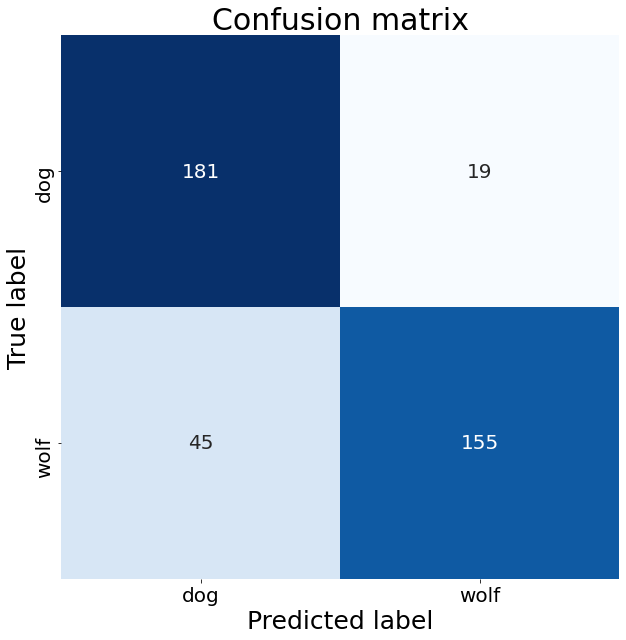

In [16]:
# confusion matrix
conf_mat = pd.DataFrame(confusion_matrix(y_true, preds))
conf_mat.index = ['dog','wolf']
conf_mat.columns = ['dog','wolf']

plt.figure(figsize = (10,10))
plt.title('Confusion matrix', size = 30)
sns.heatmap(conf_mat, annot = True,cmap='Blues', fmt='g', annot_kws={"fontsize":20}, cbar = False)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel('Predicted label', size = 25)
plt.ylabel('True label', size = 25)
plt.show()

### As we can see our model is pretty good very well, it scored 0.84% accuracy but it is much better for dogs.